## <font color='aqua'> This will be a Bispectra Theory Comparison to confirm that the Bispectrum Calculator works. </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import healpy as hp
import pickle
import numba as nb
import spherical
import pywigxjpf
import pywigxjpf_ffi
import numba_progress
import math
import scipy

from tqdm.notebook import tqdm
from spherical import Wigner3j
from scipy import stats

try:
    from pywigxjpf_ffi import ffi, lib
except ImportError:
    from pywigxjpf.pywigxjpf_ffi import ffi, lib

from numba import jit, njit, prange, set_num_threads
from numba_progress import ProgressBar
from numba.core.typing import cffi_utils as cffi_support
cffi_support.register_module(pywigxjpf_ffi)

nb_wig3jj = pywigxjpf_ffi.lib.wig3jj

from helper_funcs import *

In [3]:
lmax = 1000

ells = np.arange(lmax+1)

cls = np.zeros_like(ells, dtype='float')

for l in ells[1:]:
    cls[l] = (l+0.0)**(-3.)

theory_map, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=np.max(ells), alm=True)

ana_cls = hp.anafast(theory_map, lmax=lmax)
sorted_alms = sort_alms(alms, len(cls))
computed_cls = compute_cls(sorted_alms)
print(len(cls), len(ana_cls), len(computed_cls), len(sorted_alms), max(sorted_alms.keys()))

1001 1001 1001 1001 1000


0.0 180.0 -180.0 180.0


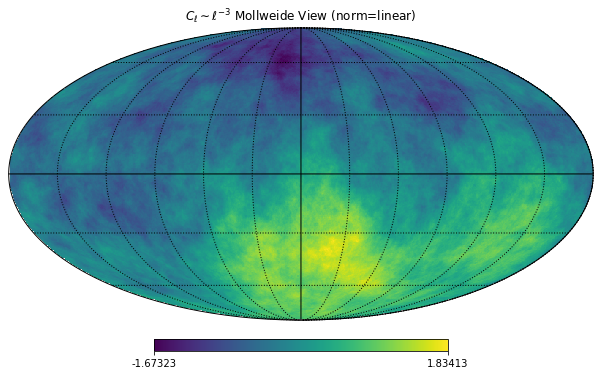

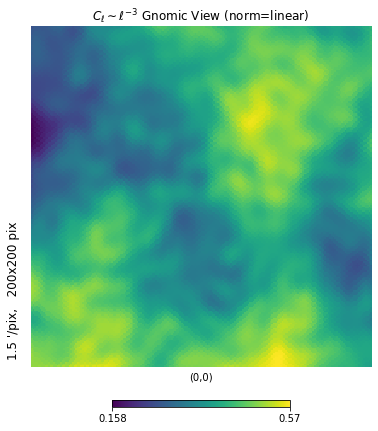

In [4]:
hp.mollview(theory_map, title='$C_{\ell} \sim {\ell}^{-3}$ Mollweide View (norm=linear)')
hp.graticule()

hp.gnomview(theory_map, title='$C_{\ell} \sim {\ell}^{-3}$ Gnomic View (norm=linear)')

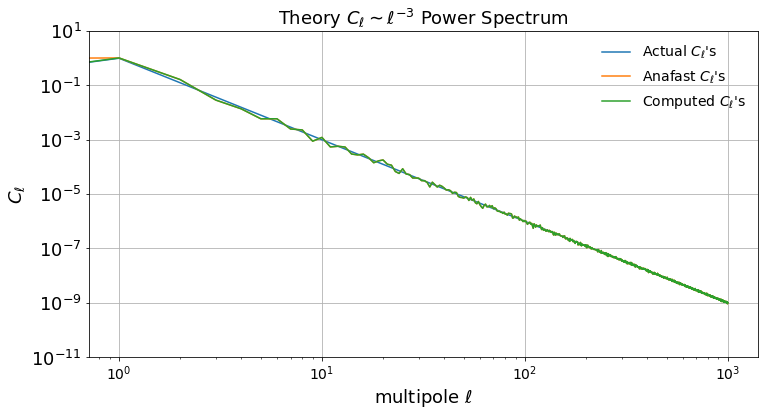

In [5]:
cls_list = [cls, ana_cls, computed_cls]
cls_labels = ["Actual $C_{\ell}$'s", "Anafast $C_{\ell}$'s", "Computed $C_{\ell}$'s"]

plot_cl(ells, cls_list, labels=cls_labels, ylim=(1e-11,1e1), title="Theory $C_{\ell} \sim \ell^{-3}$ Power Spectrum")

/tmp/ipykernel_18481/2514389750.py:1: RuntimeWarning: invalid value encountered in true_divide
  frac_residual = (computed_cls - cls) / (cls)


Text(0.5, 1.0, "(Computed $C_{\\ell}$'s - $\\ell^{-3}$) / $\\ell^{-3}$")

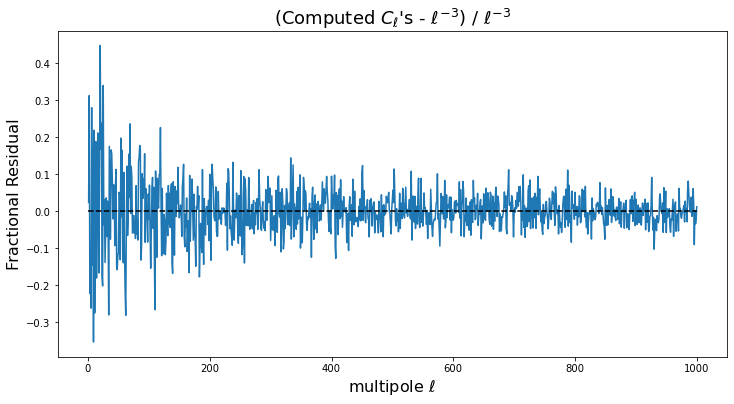

In [6]:
frac_residual = (computed_cls - cls) / (cls)

plt.figure(figsize=(12,6))
plt.plot(ells, frac_residual)
plt.plot(ells, np.zeros_like(ells),'k--')
plt.xlabel("multipole $\ell$", fontsize=16)
plt.ylabel("Fractional Residual", fontsize=16)
plt.title("(Computed $C_{\ell}$'s - $\ell^{-3}$) / $\ell^{-3}$", fontsize=18)

In [7]:
# find_stats(theory_map, hp_map=True)

In [8]:
nside = hp.get_nside(theory_map)

pix_area = hp.nside2pixarea(nside)

# precise estimate for the overdensity

delta = theory_map * pix_area / np.mean(theory_map*pix_area) - 1

We have:

$$ B_{\ell_1\ell_2\ell_3} = \sqrt{N_{\Delta}^{\ell_1\ell_2\ell_3}} \sum_{m_1,m_2,m_3} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    m_1 & m_2 & m_3
\end{pmatrix} \langle a_{\ell_1 m_1} a_{\ell_2 m_2} a_{\ell_3 m_3} \rangle $$

such that:

$$ N_{\Delta}^{\ell_1\ell_2\ell_3} = \frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{4\pi} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    0 & 0 & 0
\end{pmatrix}^2

**Bispectrum Templates:**

For local $f_{\rm NL}$ potential, we have:

$$ \phi_{\rm NL} = \phi_{\rm Gauss} + f_{\rm NL} \left(\phi_{\rm Gauss}^2 - \langle\phi_{\rm Gauss}\rangle^2\right) $$

For $g_{\rm NL}$, we have:

$$ \phi_{\rm NL} = \phi_{\rm Gauss} + g_{\rm NL}\left(\phi_{\rm Gauss}^3\right) $$

And for non-local $f_{\rm NL}$, we have:

$$ \phi_{\rm NL} = \phi_{\rm Gauss} + f_{\rm NL}\left(\partial\phi_{\rm Gauss}^2 - \langle \partial \phi_{\rm Gauss} \rangle^2 \right)

In [9]:
bls_gauss_map = theory_map - np.mean(theory_map)

fnl = 1
bls_nongauss_map = bls_gauss_map + fnl*(theory_map**2 - np.mean(theory_map**2))

In [10]:
@njit(parallel=True)
def compute_bispec(l1, l2, l3, alms_l1, alms_l2, alms_l3, num_threads=16):

    assert (l1 + l2 + l3) % 2 == 0, "even parity not satisfied" # even parity
    assert np.abs(l1-l2) <= l3 <= l1+l2, "triangle inequality not satisfied" # triangle inequality

    bispec_sum = 0
    val_init = (max(l1, l2, l3) + 1) * 2

    set_num_threads(num_threads) # set for Roomba to be 16 threads max

    lib.wig_table_init(val_init, 3)

    lib.wig_temp_init(val_init)
    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) \
                        * (nb_wig3jj(2*l1, 2*l2, 2*l3, 0, 0, 0))**2
    lib.wig_temp_free()

    if not norm_factor:
        return 0

    for m1 in prange(-l1, l1+1):
        lib.wig_temp_init(val_init)
        for m2 in range(-l2, l2+1):
            m3 = -(m1 + m2) # noting that m1 + m2 + m3 == 0
            w3j = nb_wig3jj(2*l1, 2*l2, 2*l3, 2*m1, 2*m2, 2*m3)
            if w3j:
                exp_alms = alms_l1[m1] * alms_l2[m2] * alms_l3[m3]
                bispec_sum += w3j * np.abs(exp_alms)
        lib.wig_temp_free()
    
    lib.wig_table_free()

    return np.sqrt(norm_factor) * bispec_sum

In [11]:
t1, t2, t3 = 700, 800, 900
n1, n2, n3 = -172, -308, 480

print(f"For l1, l2, l3, m1, m2, m3 = ({t1}, {t2}, {t3}, {n1}, {n2}, {n3})\n")

lib.wig_table_init((t3 + 1) * 2, 3)
lib.wig_temp_init((t3 + 1) * 2)
print("pywigxjpf:")
pywig = nb_wig3jj(2*t1, 2*t2, 2*t3, 2*n1, 2*n2, 2*n3)
%timeit nb_wig3jj(2*t1, 2*t2, 2*t3, 2*n1, 2*n2, 2*n3)
print(f"value: {pywig}")
lib.wig_temp_free()
lib.wig_table_free()

print("\nspherical:")
spher = Wigner3j(2*t1, 2*t2, 2*t3, 2*n1, 2*n2, 2*n3)
%timeit Wigner3j(t1, t2, t3, n1, n2, n3)
print(f"value: {spher}")

For l1, l2, l3, m1, m2, m3 = (700, 800, 900, -172, -308, 480)

pywigxjpf:
1.91 ms ± 9.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
value: -0.0004933357366260865

spherical:
15.8 µs ± 91.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
value: nan


In [12]:
l1, l2, l3 = 700, 800, 900

b_wig = compute_bispec(l1, l2, l3, sorted_alms[l1], sorted_alms[l2], sorted_alms[l3])

print(b_wig)

5.514554552201555e-14


In [13]:
def equilateral_bispec(input_map, ells=np.arange(1, 500, 2), num_threads=16):

    lmax = np.max(ells)
    alms = hp.map2alm(input_map)
    sorted_alms = sort_alms(alms, lmax+1)

    bls = {}
    
    for l in tqdm(ells, "Looping over even equilateral ell-triplets"):
    # for l in ells:
        bls[l] = compute_bispec(l, l, l, sorted_alms[l], sorted_alms[l], sorted_alms[l], num_threads=num_threads)
    
    return bls

In [14]:
l1, l2, l3, = 100, 100, 100

b_wig = compute_bispec(l1, l2, l3, sorted_alms[l1], sorted_alms[l2], sorted_alms[l3])
# b_sph = compute_bispec_jit(l1, l2, l3, sorted_alms[0], sorted_alms[1], sorted_alms[2])

In [15]:
lmin = 30
lmax = 400
space = 20
ells = np.arange(lmin, lmax, space)

bls_gauss = equilateral_bispec(bls_gauss_map, ells)
# bls_nongauss = equilateral_bispec(bls_nongauss_map, ells)

Looping over even equilateral ell-triplets:   0%|          | 0/19 [00:00<?, ?it/s]

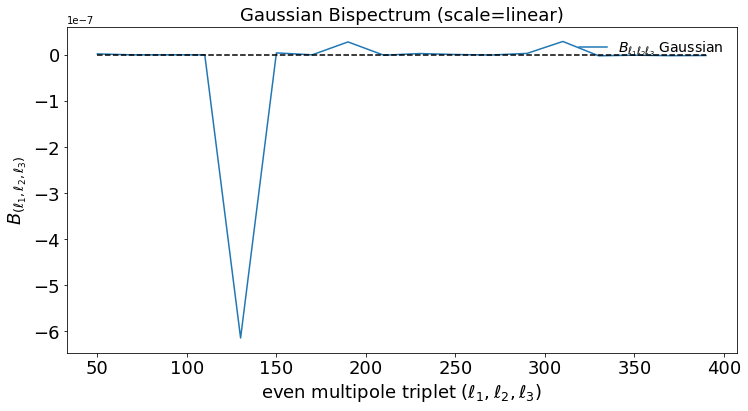

In [16]:
# bls_list = [bls_gauss, bls_nongauss]
bls_labels = ["$B_{\ell_1 \ell_2 \ell_3}$ Gaussian", "$B_{(\ell_1 \ell_2 \ell_3)}$ Non-Gaussian"]

xlmin = 20
xlmax = None

plot_bispec_eq([bls_gauss], labels=[bls_labels[0]], xlmin=xlmin, xlmax=xlmax, title="Gaussian Bispectrum (scale=linear)")
# plot_bispec_eq(bls_list, labels=bls_labels, xlmin=xlmin, xlmax=xlmax, title="Gaussian vs. Non-Gaussian Bispectrum (scale=linear)")

In [17]:
lmax = 250
sorted_alms = sort_alms(hp.map2alm(bls_gauss_map), lmax+1)

In [18]:
# check_locs = np.arange(50, 500+1, 50)
# percent_avg = np.zeros_like(check_locs)

# print("Ell \t Max \t Percent")
# for i,loc in enumerate(check_locs):
#     bls_gauss_test = bispec_range(bls_gauss_map, lmax=loc, scheme='e', ell_interval=2)
#     bls_gauss_vals = np.abs(split_bls(bls_gauss_test, get='bls'))
#     max_val_loc = int(np.argwhere(bls_gauss_vals == np.max(bls_gauss_vals[10:])))*2
#     percent_loc = (max_val_loc / loc) * 100
#     percent_avg[i] = percent_loc
#     print("{} \t {} \t {:.2f}%".format(loc, max_val_loc, percent_loc))

# print("Percent Average Location of Max Val: {:.2f}%".format(np.mean(percent_avg)))

In [19]:
def run_over_maps(seed_start=160989, nmaps=10, ells=np.arange(1,1024,1), ls=np.array([100,200]), fnl=1, nongauss=False):
    lmax = np.max(ells)
    cls = (ells+0.0)**(-3.)
    bls_maps = np.zeros((nmaps, len(ls)), dtype='float')
    alms_sums_maps = np.zeros((nmaps, len(ls)), dtype='float')
    for i in tqdm(range(nmaps)):
        np.random.seed(seed_start+i)
        theory_map, alms = hp.sphtfunc.synfast(cls=cls, nside=1024, lmax=lmax, alm=True)
        if nongauss:
            nongauss_map = theory_map - np.mean(theory_map) + fnl*(theory_map**2 - np.mean(theory_map**2))
            alms = hp.map2alm(nongauss_map)
        sorted_alms = sort_alms(alms, lmax+1)
        bls = np.zeros_like(ls, dtype='float')
        for j,l in enumerate(ls):
            bls[j] = compute_bispec(l, l, l, sorted_alms[l], sorted_alms[l], sorted_alms[l])
        bls_maps[i] = bls
    return bls_maps

In [20]:
nmaps = 25
lmin = 30
lmax = 300
space = 30

ls = np.arange(lmin, lmax+1, space)
bls_maps = run_over_maps(ls=ls, nmaps=nmaps)
# bls_maps_ng = run_over_maps(ls=ls, nmaps=nmaps, nongauss=True)

  0%|          | 0/25 [00:00<?, ?it/s]

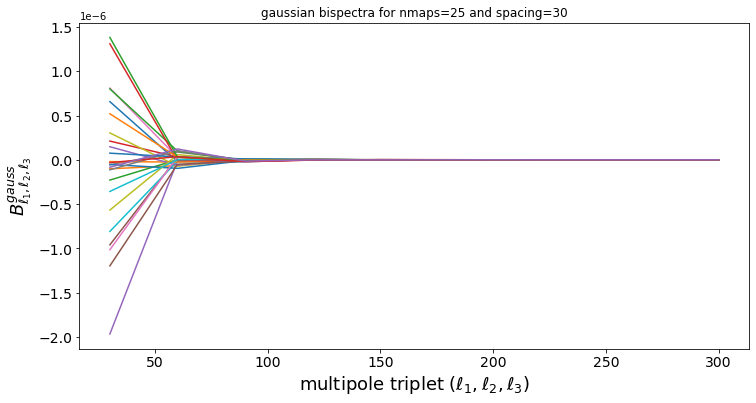

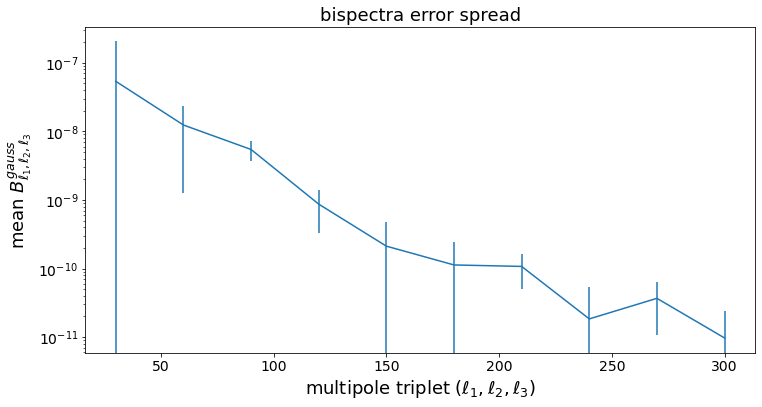

In [21]:
plt.figure(figsize=(12,6))
for i in range(nmaps):
    plt.plot(ls, bls_maps[i])
plt.title(f"gaussian bispectra for nmaps={nmaps} and spacing={space}")
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("$B^{gauss}_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.show()
plt.figure(figsize=(12,6))
plt.errorbar(ls, np.abs(np.mean(bls_maps, 0)), np.std(bls_maps, 0)/np.sqrt(nmaps))
plt.title("bispectra error spread", fontsize=18)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("mean $B^{gauss}_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
plt.yscale('log')
plt.show()

In [22]:
# plt.figure(figsize=(12,6))
# for i in range(nmaps):
#     plt.plot(ls, bls_maps_ng[i])
# plt.title(f"nongaussian bispectra for nmaps={nmaps} and spacing={space}", fontsize=18)
# plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
# plt.ylabel("$B^{nongauss}_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
# plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# plt.show()
# plt.figure(figsize=(12,6))
# plt.errorbar(ls, np.abs(np.mean(bls_maps_ng, 0)), np.std(bls_maps_ng, 0)/np.sqrt(nmaps))
# plt.title("bispectra error spread", fontsize=18)
# plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
# plt.ylabel("mean $B^{nongauss}_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
# plt.yscale('log')
# plt.show()

Let's look at the theoretical variance, given by:

$$ \operatorname{Var}\left(B_{\ell_{1} \ell_{2} \ell_{3}}\right)=g_{\ell_{1} \ell_{2} \ell_{3}} N_{\Delta}^{\ell_{1} \ell_{2} \ell_{3}} C_{\ell_{1}} C_{\ell_{2}} C_{\ell_{3}} \equiv V_{\ell_{1} \ell_{2} \ell_{3}} $$

such that $N_{\Delta}^{\ell_1 \ell_2 \ell_3}$ is as before, namely:

$$ N_{\Delta}^{\ell_1\ell_2\ell_3} = \frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{4\pi} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    0 & 0 & 0
\end{pmatrix}^2 $$

and $g_{\ell_1 \ell_2 \ell_3}$ is equal to either 6, 2, or 1 depending on whether 3, 2, or no $\ell$'s are equal respectively. This implies that, for the equilateral case we're dealing with above, $g_{\ell_1 \ell_2 \ell_3} = 6$, giving us a variance of:

$$ V_{\ell_1 \ell_2 \ell_3} = 6 \cdot N_{\Delta}^{\ell_1 \ell_2 \ell_3} \cdot C_{\ell_1} C_{\ell_2} C_{\ell_3} $$

It should be noted that, for the binned bispectrum $ B_{i_1 i_2 i_3} = (\Xi_{i_1 i_2 i_3})^{-1} \sum_{\ell_1\in\Delta_1}\sum_{\ell_2\in\Delta_2}\sum_{\ell_3\in\Delta_3} B_{\ell_1 \ell_2 \ell_3} $ where $\Xi_{i_1 i_2 i_3}$ is the number of $\ell$ triplets within the $(i_1,i_2,i_3)$ bin triplet satisfying the triangle
inequality and parity condition selection rule, the variance $\operatorname{Var} (B_{i_1 i_2 i_3})$ is:

$$ \operatorname{Var} (B_{i_1 i_2 i_3}) = \frac{g_{i_1 i_2 i_3}}{(\Xi_{i_1 i_2 i_3})^2} \sum_{\ell_1\in\Delta_1}\sum_{\ell_2\in\Delta_2}\sum_{\ell_3\in\Delta_3} N_{\Delta}^{\ell_1 \ell_2 \ell_3} C_{\ell_1} C_{\ell_2} C_{\ell_3} \equiv V_{i_1 i_2 i_3} $$

In [23]:
def find_bispec_var(l1, l2, l3, binned=False):
    norm_factor = ((l1 * 2 + 1) * (l2 * 2 + 1) * (l3 * 2 + 1))/(4 * np.pi) * (get_w3j(l1, l2, l3, 0, 0, 0))**2
    ells = np.array([l1, l2, l3])
    cls = (ells+0.0)**(-3.)
    if not binned:
        if l1 == l2 == l3:
            g = 6
        elif l1 != l2 != l3:
            g = 1
        else:
            g = 2
        return g * norm_factor * np.prod(cls)
    else:
        return norm_factor * np.prod(cls)

def find_bispec_var_binned(ls):
    bls_var = np.zeros_like(ls, dtype='float')
    xi = 0
    lib.wig_temp_init((lmax + 1) * 2)
    for i,l1 in enumerate(ls):
        for l2 in ls:
            for l3 in ls:
                xi += 1
                bls_var[i] += find_bispec_var(l1, l2, l3, binned=True)
    lib.wig_temp_free()

    return 6/(xi**2) * bls_var


In [24]:
bls_var = np.zeros_like(ls, dtype='float')

lib.wig_table_init((lmax + 1) * 2, 3)

for i, l in enumerate(ls):
    lib.wig_temp_init((lmax + 1) * 2)
    bls_var[i] = find_bispec_var(l, l, l)
    lib.wig_temp_free()

bls_var_binned = find_bispec_var_binned(ls)

lib.wig_table_free()

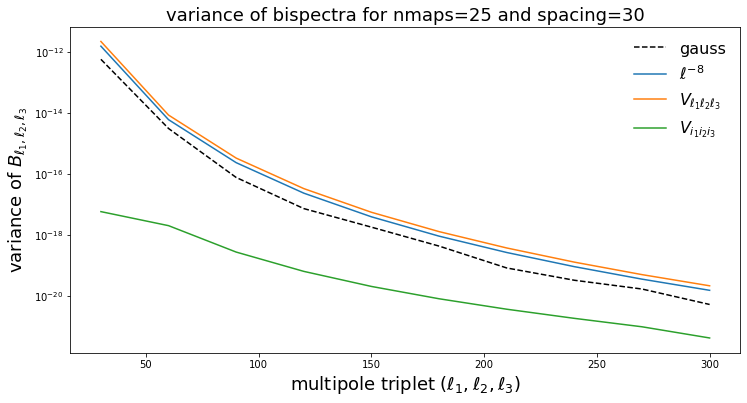

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(ls, np.std(bls_maps, 0)**2, 'k--', label="gauss")
# plt.plot(ls, np.std(bls_maps_ng, 0)**2, 'r:', label="nongauss")
plt.plot(ls, (ls+0.0)**(-8), label="$\ell^{-8}$")
plt.plot(ls, bls_var, label="$V_{\ell_1 \ell_2 \ell_3}$")
plt.plot(ls, bls_var_binned, label="$V_{i_1 i_2 i_3}$")
plt.legend(frameon=False, loc='upper right', fontsize=16)
plt.title("variance of bispectra for nmaps={} and spacing={}".format(nmaps, space), fontsize=18)
plt.xlabel("multipole triplet $(\ell_1,\ell_2,\ell_3)$", fontsize=18)
plt.ylabel("variance of $B_{\ell_1, \ell_2, \ell_3}$", fontsize=18)
plt.yscale('log')
plt.show()